# Training the LdaModel on conversation data

In [1]:
import os
import numpy as np
import aesthetix as at

# Downloading movie_lines
if "movie_lines.txt" not in os.popen("ls").read():
  !wget https://raw.githubusercontent.com/Stellarator-X/ConvoBot/servus/Programming%20Assignments/Response%20Generation/movie_lines.txt

movielines = open("movie_lines.txt", mode='r')
print(movielines)
lines = movielines.readlines()
print(len(lines))

def clean_str(_str):
  _str = _str.strip()
  _str = _str.lower()
  _str = _str.replace(".", "")
  _str = _str.replace(",", "")
  _str = _str.replace("?", "")
  _str = _str.replace("!", "")
  _str = _str.replace(":", "")
  _str = _str.replace(">", "")
  _str = _str.replace("<", "")
  _str = _str.replace("-", " ")
  _str = _str.replace("_", " ")
  _str = _str.replace("\\", "")
  _str = _str.replace("  ", " ")
  return _str



<_io.TextIOWrapper name='movie_lines.txt' mode='r' encoding='UTF-8'>
304713


In [ ]:
sample_size = 20000
cleanlines = []
for i, line in enumerate(lines[:sample_size]):
  at.progress_bar("Cleaning the lines", i, len(lines[:sample_size]))
  speaker, line = line.split('+++$+++ ')[-2:]
  cleanlines.append([speaker.split(" ")[0], line.split('\n')[0]])

cleanlines.reverse()
cleanlines = np.array(cleanlines)
for line in cleanlines[:10]:
  print(line[0],":",line[1])


# Forming the dataset 
response_data = []
l = len(cleanlines)-1
for i, line in enumerate(cleanlines[:-1]):
  at.progress_bar("Generating Stimulus-Response Pairs", i, l)
  speaker, utterance = line
  next_speaker, next_utterance = cleanlines[i+1]
  if speaker is not next_speaker:
    response_data.append(np.array(["<start> "+clean_str(utterance)+" <end>", "<start> "+clean_str(next_utterance)+" <end>"]))
  
response_data = np.array(response_data)
print(response_data.shape)
print(response_data[-10:])

Cleaning the lines:[==============================](100.00%)  
PRINCESS : Sir, I... come to beg you to confess all, and swear allegiance to the king, that he might show you mercy.
WALLACE : Will he show mercy to my country? Will he take back his soldiers, and let us rule ourselves?
PRINCESS : Mercy... is to die quickly. Perhaps even live in the Tower. In time, who knows what can happen, if you can only live.
WALLACE : If I swear to him, then everything I am is dead already.
PRINCESS : You will die! It will be awful!
WALLACE : Every man dies. Not every man really lives.
PRINCESS : Drink this! It will dull your pain.
WALLACE : It will numb my wits, and I must have them all. If I'm senseless, or if I wail, then Longshanks will have broken me.
PRINCESS : I can't bear the thought of your torture. Take it!
NICOLETTE : When the king returns he will bury them in those new clothes. Scotland is in chaos. Your husband is secretly sending an army north.
Generating Stimulus-Response Pairs:[========

In [3]:
# Preprocessing the Data
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences

oov_token = "<OOV>"
max_length = 25
stimuli = response_data[:, 0]
responses = response_data[:, 1]

tokenizer = Tokenizer(oov_token=oov_token, filters = "")
tokenizer.fit_on_texts(stimuli)
# with open("Tokens.txt") as file:
#   json_string = file.read()
# tokenizer = tokenizer_from_json(json_string)

word_index = tokenizer.word_index
index_word = {word_index[word]:word for word in word_index}
vocab_size = len(word_index)
stimulus_sequences = tokenizer.texts_to_sequences(stimuli)
response_sequences = tokenizer.texts_to_sequences(responses)

padded_stimulus_sequences = pad_sequences(stimulus_sequences, maxlen = max_length ,padding = 'post', truncating = 'post')
padded_response_sequences = pad_sequences(response_sequences, maxlen = max_length, padding = 'post', truncating = 'post')


In [4]:
print(padded_stimulus_sequences[0])

[   2  142    5   91    7 1104    4    7 1823   38   10  623 4577    7
    6  893   14   26  245  223    4 1668    3    0    0]


In [5]:
json_string = tokenizer.to_json()
with open("Tokens.txt", "w") as file:
  file.write(json_string)

In [6]:
from gensim.models.ldamodel import LdaModel



In [7]:
def build_lda_corpus(sequences, verbose = False):
  corpus = []
  net = len(sequences)
  for num, line in enumerate(sequences):
    if verbose : at.progress_bar("Generating the Corpus  : ", num, net)
    counts = [list(line).count(elt) for elt in line]
    line_ = list(set([(line[i], counts[i]) for i in range(len(counts))]))
    corpus.append(line_)
  return corpus


In [ ]:
lda_corp = build_lda_corpus(padded_stimulus_sequences, verbose = True)

Generating the Corpus  : :[==============================](99.15%)  

In [ ]:
index_word[0] = "<OOV>"

In [10]:
ConvLda = LdaModel(lda_corp, num_topics = 100, id2word=index_word)

/usr/local/lib/python3.6/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [11]:
ConvLda.save("LDA.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


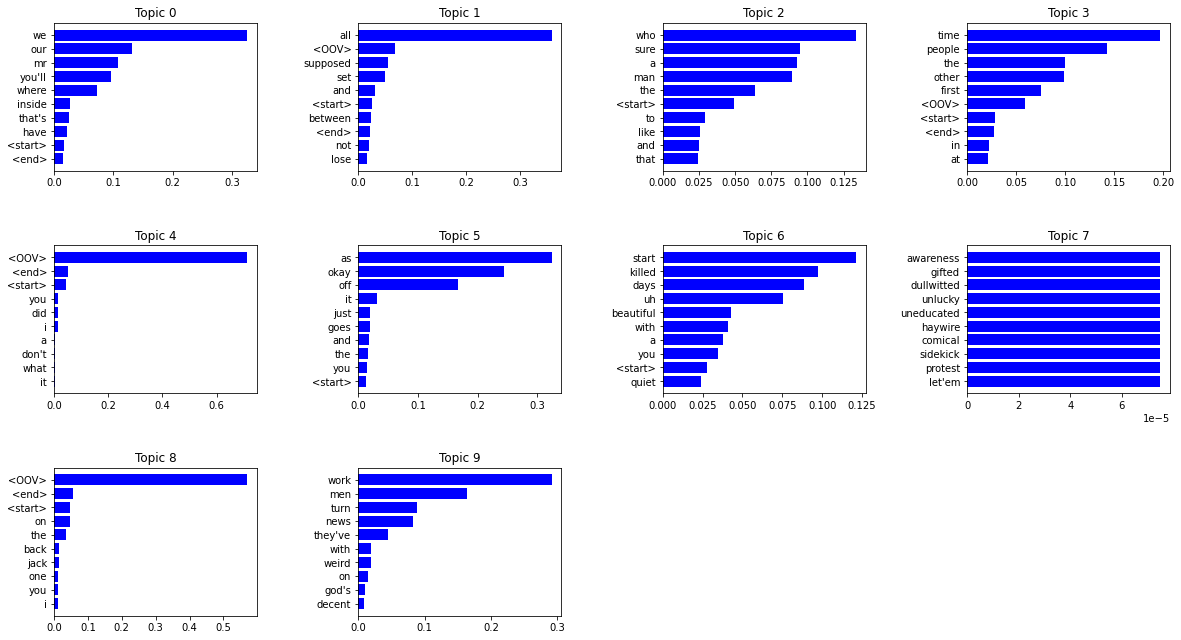

In [12]:
# Getting the topic words for the first 10 topics
from matplotlib import pyplot as plt, gridspec
import math

def plot_top_words(lda=ConvLda, nb_topics=10, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(nb_topics))+1,round(math.sqrt(nb_topics))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()